In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from os.path import join, isfile
import cv2
import cvlib as cv

Using TensorFlow backend.
/home/luke/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luke/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luke/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/luke/anaconda3/lib/python3.6/site-packages/tensorflow/py

# Notebook Structure
> The notebook studies the dataset and explores the different approaches to generate t-shirt images from a text description. It does not contain code for the GANS because of the short deadline and the lack of appropriate hardware to train the models.  
The following structure is applied :
1. Dataset study
2. Image optimization
3. ML approaches

## Dataset Study
> We look at the data and balance it if necessary

In [2]:
# Load dataframe and remove the category column (always 'Tshirt')
df = pd.read_csv(join('data', 'myntra_train_dataset.csv')).drop('Category', axis=1)

# What information is contained in the dataframe ?
df.describe()

,Brand,Gender,Color,Link_to_the_image,Sub_category
count,70000,70000,69677,68870,70000
unique,378,5,44,68797,24
top,Puma,Men,Blue,http://lacoste.in/media/catalog/product/p/f/pf...,Solid
freq,4889,48910,10373,3,22350


For each T-shirt we get the following information :
* brand 
* gender
* color
* sub-category
* image

a common tshirt would be a Blue Puma T-shirt for men.  
We drop the T-shirts with no matching image.

In [3]:
# Drop entries with missing info
df = df.dropna()

# Actual number of entries after the drop
print("The data contains {} T-shirts after dropping entries with missing information.".format(len(df)))

The data contains 68845 T-shirts after dropping entries with missing information.


### How are the T-shirts types distributed ?
> A text-driven GAN should be given enough information about each type of T-shirt we want it to generate, we make sure it is the case. 

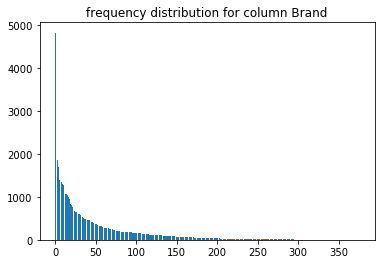

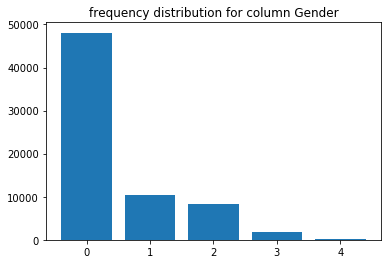

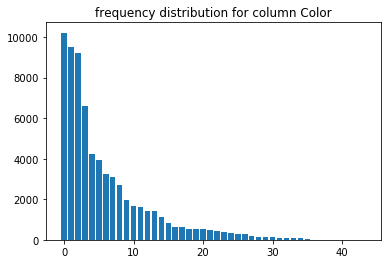

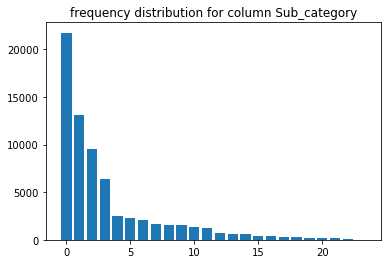

In [4]:
for col in df.columns :
    if col != 'Link_to_the_image' :
        
        # Frequencies of distinct values in the given column
        heights = df[col].value_counts().values
        indices = range(len(heights))
        
        # Plot the frequencies in a bar plot
        plt.title("frequency distribution for column {}".format(col))
        plt.bar(indices, heights)
        plt.show()
                  

Those are mainly power law distributions, We should not consider labels with too few images (e.g. less than 300) because the model cannot learn from so few. Thus, we clean our database to keep only frequent T-shirt types.

In [5]:
"""Keep only T-shirts whose characteristics are shared among more than *threshold* other T-shirts"""
def only_common_types(df, threshold=300) :
    to_drop = None
        
    for col in df.columns :
        if col != "Link_to_the_image" :

            # Compute entries with less than *threshold* occurences 
            col_count = df[col].value_counts() 
            drop_values = col_count[col_count < threshold].index

            # Remember to drop those entries
            col_drop = df[col].isin(drop_values)

            if to_drop is None :
                to_drop = col_drop
            else :
                col_drop = col_drop & to_drop
                
    return df[~to_drop]

In [6]:
# Keep only common T-shirt characteristics 
df = only_common_types(df)

print("A dataset with only common T-shirt characteristics contains {} images.".format(len(df)))

A dataset with only common T-shirt characteristics contains 50312 images.


## Image optimization
> We now look at the images and study how to improve their format

In [7]:
"""Plot a serie of images given a url-to-image function"""
def plot_images(url_to_image_func) :
    # We visualize original pictures
    nrows=2 
    ncols=4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11,5))

    for row in range(nrows) :
        for col in range(ncols) :
            url = df['Link_to_the_image'][row*ncols + col]
            image = url_to_image_func(url)
            axes[row, col].imshow(image)

"""Return the image stored at the given url"""
def get_image(url) :
    image = io.imread(url) 
    return image

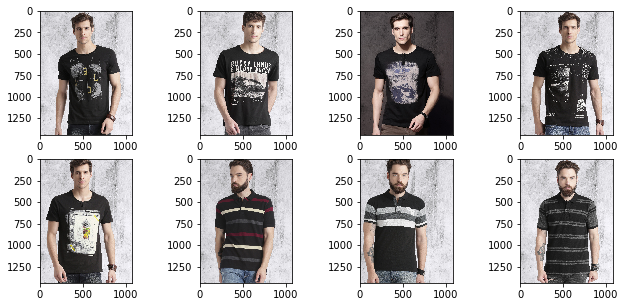

In [8]:
# We visualize original pictures
plot_images(get_image)

GANS are costlier to train as the images they process get bigger. Thus, it is a good practice to try to reduce the image size as much as possible.   
Here, we see that some pixels do not encode the T-shirt but rather the background or the model. Consequently, we get rid of them to have a lower-dimensional input and thus reduce computational costs. This is done by applying **cropping**.  
Additionally, we do not need that big a resolution to get an idea of what the t-shirt looks like. We reduce the resolution by applying **downsampling**.

### Boundary-based cropping
> We hardcode boundaries by looking at the images to capture only the T-shirt

In [9]:
"""Load an image from a url and crop/downsample it using hardcoded boundaries"""
def load_and_crop_image(url, boundaries=(450,1010, 250, 810), downscale=5) :
    
    t, b, l, r = boundaries
    
    # Read the image from url
    image = io.imread(url)
    
    # Crop the image and downscale it
    cropped_image = image[t:b:downscale,l:r:downscale,:]
    return cropped_image

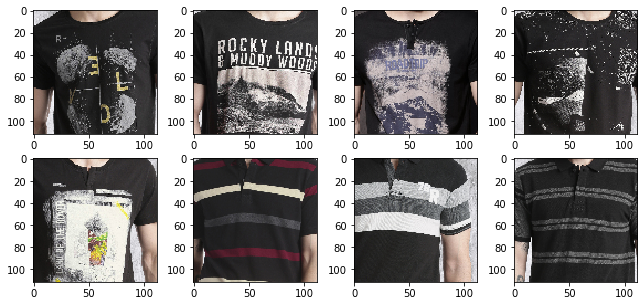

In [10]:
plot_images(load_and_crop_image)

The result is approximately centered on the T-shirt but we still see the arm sometimes, we thus try another way to crop the image, more aware of where the person is standing.

### detection-based cropping
> We define the boundaries based on a human detector (YOLO-v3)

In [11]:
def human_tshirt_bbox(url) :
    image = io.imread(url)
    bbox, label, conf = cv.detect_common_objects(image)
    
    # Draw human box
    cv2.rectangle(image, (bbox[0][0],bbox[0][1]), (bbox[0][2],bbox[0][3]), (150, 150, 255), 25)
    
    # Draw T-shirt box
    cv2.rectangle(image, (bbox[0][0]+100,bbox[0][1]+425), (bbox[0][2]-100,bbox[0][3]-200), (255, 150, 150), 25)
    
    return image

def yolo_crop_tshirt(url) :
    image = io.imread(url)
    bbox, label, conf = cv.detect_common_objects(image)
    
    # Crop and down sample image
    result_image = image[bbox[0][1]+425:bbox[0][3]-200:5, bbox[0][0]+100:bbox[0][2]-100:5]
    
    return result_image

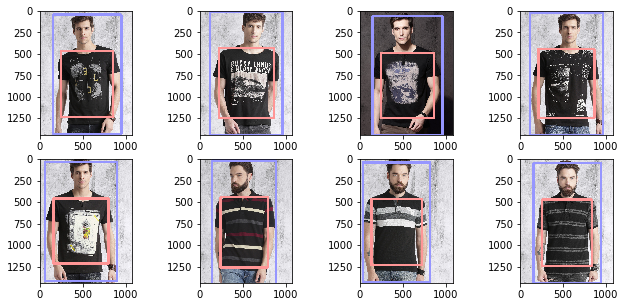

In [12]:
# Plot bounding boxes
plot_images(human_tshirt_bbox)

The detection is effective, looking only at the T-shirts gives the following

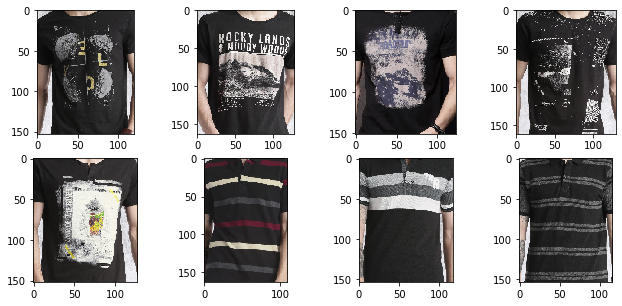

In [13]:
# Plot only cropped Tshirts
plot_images(yolo_crop_tshirt)

This time the images are well centered, we can feed the GANs with this format

## ML approaches
> There are several ways to have a GAN generate images belonging to some categories (e.g. Brand, sub-category, etc.). We explore three approaches :
1. StackGAN
2. StyleGAN
3. cGAN

### StackGAN
> StackGAN was published in 2017 by Zhang et al.. In their [paper](https://arxiv.org/pdf/1710.10916v3.pdf), they show that it is able to take raw text as input and to generate a corresponding image, as shown in the examples below.

![alt text](data/stackGAN.jpeg "StackGAN image generation")

Its architecture is composed of two GANs, the first one generatig basic colors and shapes (stage-I) and the second refining details and correcting defects (stage-II). An application to the T-shirt problem is straightforward, one could simply type the T-shirt description and get a visualization of what such a T-shirt would look like.

Whereas StackGAN achieves great results, note that it was trained on pairs of free text and image. This is a limitation because the Myntra dataset has only categorical labels such as color and shape. One should therefore consider building a free text description of those T-shirts before feeding them to StackGan.

Code for StackGAN is given [here](https://paperswithcode.com/paper/stackgan-realistic-image-synthesis-with#code)

### StyleGAN
> StyleGAN is a GAN that generates realistic images along with a latent space representation of the latter images. It was first introduced in a 2018 [paper](https://arxiv.org/pdf/1812.04948.pdf) by Karras et al., and further improved in a subsequent [publication](https://arxiv.org/pdf/1912.04958.pdf)  in 2019.  
The latent space allows to apply an image *style* to another as shown below.

![alt text](data/StyleGAN_morph.jpg "the styles of the leftmost pictures are applied to the top pictures")

An application for T-shirts would be for instance to apply a t-shirt style to another T-shirt, leading to the creation of a new T-shirt combining both clothes.  

Because it is hard to control which stype part (e.g. color, brand, size) is transmitted, one can also identify vectors in the latent space responsible for a certain characteristic. This is done by looking at the centroid of samples with a specific value for a given label. In the figure below, the centroid of *sad* and *happy* faces were identified and led to the discovery of a new vector *smile*. Moving an image representation along this vector changes how much the person smiles.  

![alt text](data/Style_smile.jpg "The smile characteristic is changed by moving in the latent space")

This allows a great control other T-shirt characteristics, on could for instance make a T-shirt more "Puma"-ey depending on the categorical labels the user chooses.  

Note that we do not need to drop uncommon labels for training this GAN, but their centroids are likely to be misplaced due to the lack of data.  

The code for the latest version of StyleGAN is given [here](https://github.com/NVlabs/stylegan2) 

### cGAN (conditional-GAN)
> cGAN generates images whose labels can be specified. For instance, if training cGAN on Nike T-shirts, one can latter ask cGAN to generate a Nike T-shirt, and even ask for multi labels (such as a Blue Puma T-shirt for men).  
cGAN is quite simple to implement and has been used successfully to generate MNIST digits, as shown below.

![alt text](data/cGAN_mnist.png "digits generated by a cGAN, each row fed a different label to the GAN")

A code for the MNIST cGAN is given [here](https://github.com/znxlwm/tensorflow-MNIST-cGAN-cDCGAN)